# Correcting absolute hydration free energies using support vector machines - null test

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Global-variables" data-toc-modified-id="Global-variables-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Global variables</a></span></li><li><span><a href="#Path-variables" data-toc-modified-id="Path-variables-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Path variables</a></span><ul class="toc-item"><li><span><a href="#Convergence-plot" data-toc-modified-id="Convergence-plot-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convergence plot</a></span></li></ul></li><li><span><a href="#External-testing" data-toc-modified-id="External-testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>External testing</a></span><ul class="toc-item"><li><span><a href="#Pearson-R" data-toc-modified-id="Pearson-R-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Pearson R</a></span></li><li><span><a href="#Mean-absolute-error" data-toc-modified-id="Mean-absolute-error-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Mean absolute error</a></span></li><li><span><a href="#Linear-combination" data-toc-modified-id="Linear-combination-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Linear combination</a></span></li><li><span><a href="#Load-test-data" data-toc-modified-id="Load-test-data-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Load test data</a></span></li><li><span><a href="#Predict-$\Delta-G_{hydr}$" data-toc-modified-id="Predict-$\Delta-G_{hydr}$-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Predict $\Delta G_{hydr}$</a></span></li></ul></li></ul></div>

## Imports

In [1]:
# General:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
import time
import scipy
import shutil
import logging
import pickle
import statistics
from tqdm import tqdm_notebook as tqdm
from uncertainties import unumpy

# SVM:
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from skopt import gp_minimize, dump, load
os.environ["CUDA_VISIBLE_DEVICES"]="3"  # current workstation contains 4 GPUs; exclude 1st

# SciKit-Optimise:
from skopt import gp_minimize, dump
from skopt.space import Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence

# Statistics:
from uncertainties import unumpy
import itertools
itertools.imap = lambda *args, **kwargs: list(map(*args, **kwargs))

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Global variables

In [2]:
# Global variables:
model_type = 'null_DNN'
label_col = 'Experimental dGhydr (kcal/mol)'
# label_col = 'dGoffset (kcal/mol)'
label_u_col = 'uncertainty (kcal/mol)'

# set data processing configurations:
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
best_mae = np.inf  # Point to consider top-performing model from (MAE/MAD); 1.0 = no improvement on test-set variance

# KFold parameters:
n_splits = 5  # Number of K-fold splits
random_state = 2  # Ranom number seed

# DNN global variables
n_calls = 60  # Number of Bayesian optimisation loops for hyperparameter optimisation, 40 is best for convergence, > 60 scales to very expensive
epochs = 200
best_mae = np.inf

## Path variables

In [3]:
# Path variables:
path = './'
datasets_dr = '../datasets/'
SDF_dr = datasets_dr + 'sdffiles/'
output_dr = path + 'output_null/'
if not os.path.exists(output_dr):
    os.mkdir(output_dr)
figures_dr = path + 'figures_null/'
if not os.path.exists(figures_dr):
    os.mkdir(figures_dr)
freesolv_loc = datasets_dr + 'freesolv_database.txt'

### Convergence plot

Load gp_minimize objects

In [4]:
# gp_minimize object
gp_results = [load(output_dr + 'fold_' + str(fold_num) +  '_gp_minimize_result.pickle') 
              for fold_num in range(1, n_splits + 1)]
# lsit of MAE and associated parameters
mae_logger = pd.read_csv(output_dr + 'DNN_statistics.csv')

/home/wwu/anaconda3/envs/freesolv/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.20.0 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Plot function convergence over number of calls

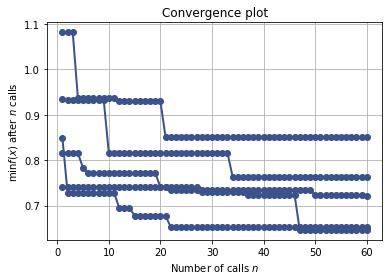

In [5]:
for result in gp_results: plot_convergence(result)
plt.savefig(figures_dr + 'convergence_plot.png')

## External testing

### Pearson R


$
  r =
  \frac{ \sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}) }{%
        \sqrt{\sum_{i=1}^{n}(x_i-\bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i-\bar{y})^2}}
$

In [6]:
def calc_pearson_r(x, y):
    """
    Calculates Pearson R value.
    Assumes len(x) == len(y).
    Parameters
    ----------
    x: array like of uncertainties.core.Variable
    y: array like of uncertainties.core.Variable
    ----------
    Returns array like of uncertainties.core.Variable
    """
    n = len(x)  # number of samples
    x_norm = [i.n for i in x]  # x without uncertainty
    y_norm = [i.n for i in y]  # y without uncertainty
    sum_x = float(sum(x_norm))  # sum of x
    sum_y = float(sum(y_norm))  # sum of y
    sum_x_sq = sum(itertools.imap(lambda x: pow(x, 2), x))  # sum of x**2
    sum_y_sq = sum(itertools.imap(lambda x: pow(x, 2), y))  # sum of y**2
    psum = sum(itertools.imap(lambda x, y: x * y, x, y))  # sum of x*y
    num = psum - (sum_x * sum_y/n)  # Pearson R equation numerator
    den = pow((sum_x_sq - pow(sum_x, 2) / n) * (sum_y_sq - pow(sum_y, 2) / n), 0.5)  # Pearson R formular demoninator
    if den == 0: return 0  # Prevent division by zero
    return num / den

### Mean absolute error


$
<insert \: formula>
$

In [7]:
def calc_mae(x, y):
    """Returns list of mean absolute error between two lists.
    Assumes len(x) == len(y)."""
    ae = [abs(i - j) for i, j in zip(x, y)]
    return sum(ae) / len(ae)

### Linear combination

In [8]:
def sum_error(error1, error2):
    """Returns sum propagated error between two int or floats."""
    return (error1 ** 2 + error2 ** 2) ** 0.5

### Load test data

In [9]:
test_X = pd.read_csv(datasets_dr + 'null_test_data.csv',
                     index_col='ID').iloc[:,0:-2]

test_y = pd.read_csv(filepath_or_buffer=datasets_dr + 'null_test_data.csv',
                     index_col='ID').iloc[:,-2:-1]

# propagated error of dGoffset label
test_y_u = pd.read_csv(datasets_dr + 'null_test_data.csv',
                       index_col='ID').iloc[:,-1].sort_index()

In [10]:
# load experimetnal dGhydr column from freesolv
exp_dGhydr = pd.read_csv(filepath_or_buffer=datasets_dr + 'freesolv_database.txt',
                         sep='; ',
                         engine='python',
                         usecols=['compound id (and file prefix)', 'experimental value (kcal/mol)'],
                         index_col='compound id (and file prefix)'
                        ).sort_index()

### Predict $\Delta G_{hydr}$

In [11]:
def model_predict(model_num, test_entry):
    """Load model from HDF5 and return model prediction on a given test_entry."""

    model = tf.keras.models.load_model(output_dr + 'dGhydr_DNN_fold_' + str(model_num) + '_model.h5')

    return model.predict(test_entry)

In [12]:
# ML predicted labels nested list per fold
predict_per_fold = [model_predict(fold_num, test_X.to_numpy()) for fold_num in range(1, n_splits + 1)]
predict_per_fold = [np.asarray([x[0] for x in fold.tolist()]) for fold in predict_per_fold]
# average ML predicted labels
predict_y = np.average(predict_per_fold, axis=0)
# convert np array to float
predict_y = [float(x) for x in predict_y]
# standard deviation
predict_std = np.std(predict_per_fold, axis=0)

In [13]:
def plot_scatter(x, y, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot.
    x: (list) calculated or predicted data.
    y: (list) true or experimental data.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # absolute error
    ae = [abs(i - j) for i, j in zip(x, y)]
    # mean absolute error
    mae = statistics.mean(ae)
    
    # R-squared
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(y, x)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(round(mae, 4), round(r2, 4), round(r_value, 4))
    plt.annotate(string, xy=(0, 1),
                 xytext=(12, -12), va='top',
                 xycoords='axes fraction',
                 textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

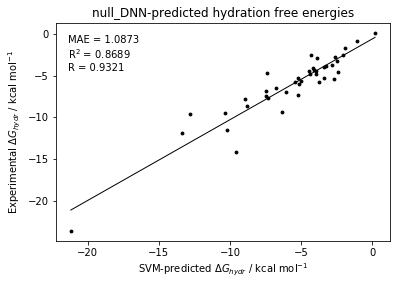

In [14]:
plot_scatter(x=predict_y,
             y=test_y[label_col].to_numpy(),
             title='{}-predicted hydration free energies'.format(model_type),
             x_label='SVM-predicted $\Delta G_{hydr}$ / kcal mol$^{-1}$',
             y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')

In [15]:
def plot_scatter_errorbar(calc, exp, title, x_label, y_label):
    """
    Returns and saves linear regression scatter plot with x-direction error bars.
    Parameters
    ----------
    calc: (list) [values, errors] calculated or predicted data with associated errors.
    exp: (list) [values, errors] true or experimental data with associated errors.
    title: (str) plot title and filename delimitted by underscores. Avoid special characters.
    x_label: (str) x-axis label.
    y_label: (str) y-axis label.
    """
    
    # regular floats
    x = calc[0]
    y = exp[0]
    
    # plot scatter
    plt.figure()
    plt.scatter(x, y, color='black', s=8)
    
    # add error bars
    plt.errorbar(x, y, xerr=calc[1], color='black', linestyle="None")

    # plot line of best fit
    # https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python
    plt.plot(np.unique(x),
             np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
             color='black', linewidth=1)

    # axis labels
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    # figure title
    plt.title(title)

    # create uncertainties.core.Variable for statistical analysis
    xu = unumpy.uarray(calc[0], calc[1])
    yu = unumpy.uarray(exp[0], exp[1])
    
    # mean absolute error
    mae = calc_mae(xu, yu)
    
    # Pearson R and R-squared
    r_value = calc_pearson_r(xu, yu)
    r2 = r_value**2

    # annotate with r-squared and MAE
    string = 'MAE = {}\nR$^2$ = {}\nR = {}'.format(mae, r2, r_value).replace('+/-', '$\pm$')
    plt.annotate(string, xy=(0, 1), xytext=(12, -12), va='top',
                 xycoords='axes fraction', textcoords='offset points')

    filename = figures_dr + str(title).lower().replace(' ', '_') + '.png'
    plt.savefig(filename)
    logging.info('Saved {}.'.format(filename))

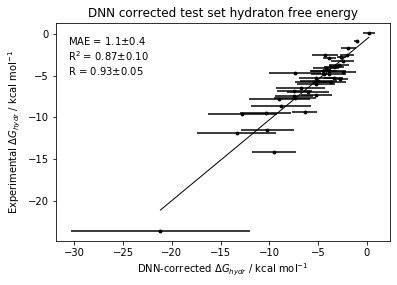

In [16]:
plot_scatter_errorbar(calc=[predict_y, predict_std],
                      exp=[test_y[label_col].to_numpy(), test_y_u.to_numpy()],
                      title='DNN corrected test set hydraton free energy'.format(),
                      x_label='DNN-corrected $\Delta G_{hydr}$ / kcal mol$^{-1}$',
                      y_label='Experimental $\Delta G_{hydr}$ / kcal mol$^{-1}$')